In [32]:
import pandas as pd
import numpy as np

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

import sys

import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier


from IPython.display import Audio

from utils.audio_preprocess import *
from utils.SepTr import *
from utils.feature_exctraction import *

In [2]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

#import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")
#warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# quante mad***e
from scikeras.wrappers import KerasClassifier

In [4]:
Crema = "CREMA-D/AudioWAV/"
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:

    file_path.append(Crema + file)

    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe 
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe Emotions/Path
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df['Emotions'] = pd.Categorical(Crema_df['Emotions'])
Crema_df.head()

,Emotions,Path
0,angry,CREMA-D/AudioWAV/1022_ITS_ANG_XX.wav
1,angry,CREMA-D/AudioWAV/1037_ITS_ANG_XX.wav
2,neutral,CREMA-D/AudioWAV/1060_ITS_NEU_XX.wav
3,neutral,CREMA-D/AudioWAV/1075_ITS_NEU_XX.wav
4,disgust,CREMA-D/AudioWAV/1073_IOM_DIS_XX.wav


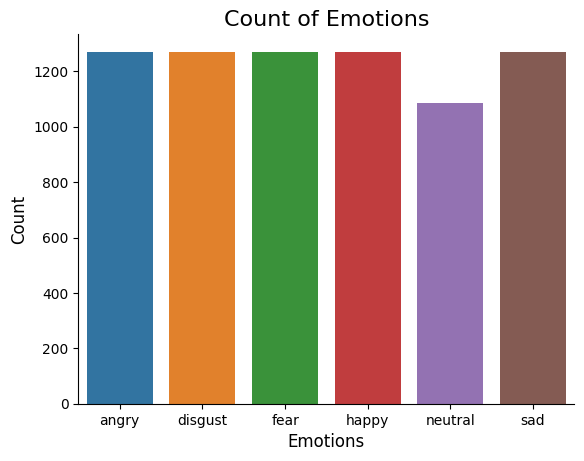

In [5]:
# Plot the count of Emotions
plt.title('Count of Emotions', size=16)
sns.countplot(data=Crema_df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
Crema_df.shape

(7442, 2)

### Data Augmentation

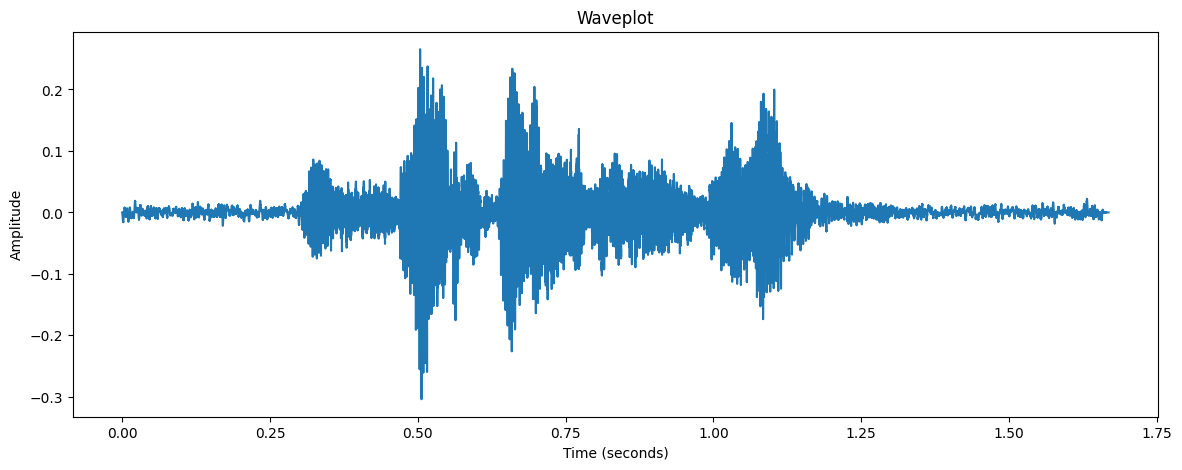

In [7]:
path = np.array(Crema_df.Path[Crema_df.Emotions=='fear'])[1]
data, sampling_rate = librosa.load(path)

duration = len(data) / sampling_rate
time = np.linspace(0, duration, len(data))

plt.figure(figsize=(14, 5))
plt.plot(time, data)
plt.title('Waveplot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()
Audio(data, rate=sampling_rate)

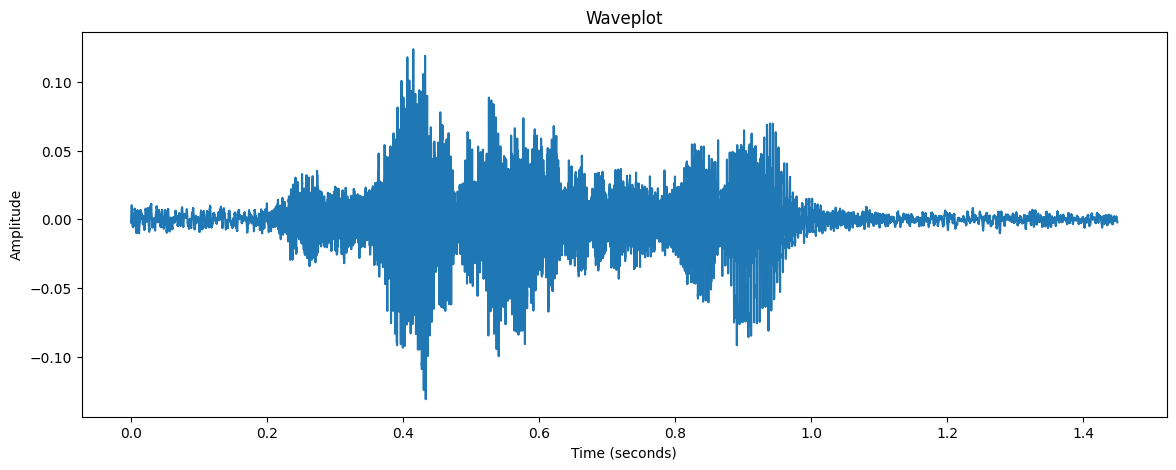

In [8]:
random_audio = random_augmentation(data, sampling_rate)

# Calculate time values
duration = len(random_audio) / sampling_rate
time = np.linspace(0, duration, len(random_audio))

# Create waveplot
plt.figure(figsize=(14, 5))
plt.plot(time, random_audio)
plt.title('Waveplot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()
Audio(random_audio, rate=sampling_rate)

### Feature Extraction

In [9]:
train, test = train_test_split(Crema_df, random_state=42, shuffle=True)

In [10]:
x_train, y_train = [], []
x_test, y_test = [], []

# TRAIN + Augmentation
for path, emotion in zip(train.Path, train.Emotions):
    feature = get_features(path, n_iter = 2)
    for ele in feature:
        x_train.append(ele)
        y_train.append(emotion)
Train = pd.DataFrame(x_train)
Train['labels'] = y_train
Train.to_csv('Data/train_synthless.csv', index=False)
Train.head()

# TEST
for path, emotion in zip(test.Path, test.Emotions):
    feature = get_features(path, synth = False)
    for ele in feature:
        x_test.append(ele)
        y_test.append(emotion)
Test = pd.DataFrame(x_test)
Test['labels'] = y_test
Test.to_csv('Data/test_synthless.csv', index=False)
Test.head()

/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.057724,0.021434,-328.098694,129.362656,1.603093,28.250675,-7.549809,-0.508716,1.917564,1.345103,...,8.036000e-09,7.320839e-09,6.836300e-09,6.490716e-09,6.242772e-09,6.069996e-09,5.948304e-09,5.871282e-09,5.824443e-09,angry
1,0.040913,0.014940,-422.495575,134.998413,20.309692,57.573116,-2.709049,24.978899,-15.263667,1.201231,...,7.019008e-11,6.662085e-11,6.391512e-11,6.179223e-11,6.017110e-11,5.901963e-11,5.817907e-11,5.764431e-11,5.732014e-11,sad
2,0.044956,0.018646,-368.973145,131.744995,8.143322,40.260132,-1.096721,6.814579,4.012649,0.106569,...,4.097419e-08,3.853548e-08,3.676714e-08,3.542807e-08,3.442318e-08,3.370419e-08,3.318075e-08,3.284814e-08,3.263901e-08,happy
3,0.062422,0.026883,-346.197937,138.361023,-13.182762,46.283558,-19.620443,12.619760,-10.991559,4.034292,...,6.982555e-08,6.486533e-08,6.133659e-08,5.869912e-08,5.672954e-08,5.531180e-08,5.427955e-08,5.361246e-08,5.319703e-08,happy
4,0.046660,0.027841,-432.640045,137.940247,20.167315,47.828022,-11.685402,30.969755,-15.280191,10.670103,...,4.504649e-09,4.032129e-09,3.708378e-09,3.474356e-09,3.303507e-09,3.181046e-09,3.093041e-09,3.035410e-09,3.000378e-09,sad


In [11]:
# info
len(x_train), len(y_train), len(x_test), len(y_test), Crema_df.Path.shape

(16743, 16743, 1861, 1861, (7442,))

In [19]:
#Train = pd.read_csv('Data/train_synthless.csv')
#Test = pd.read_csv('Data/test_synthless.csv')

In [12]:
x_train = Train.iloc[: ,:-1].values
y_train = Train['labels'].values

x_test = Test.iloc[: ,:-1].values
y_test = Test['labels'].values

# one hot encoding
encoder = OneHotEncoder()

y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()

y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [13]:
# splitting data
#x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [14]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# making our data compatible to model.
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16743, 162), (16743, 6), (1861, 162), (1861, 6))

### PCA

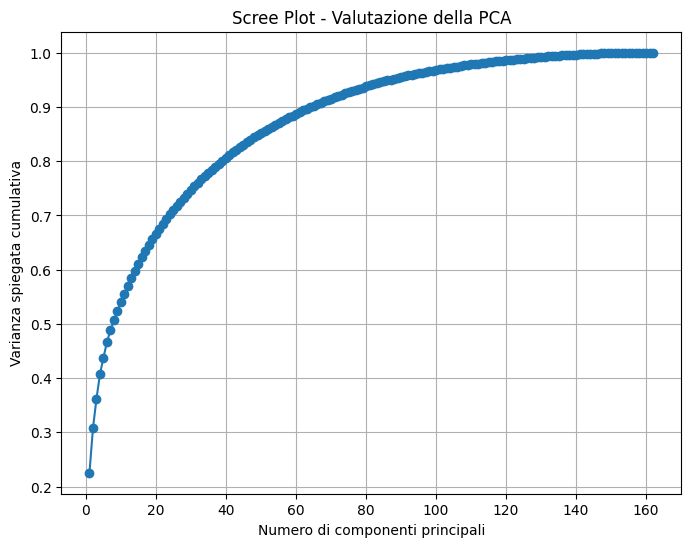

In [15]:
pca = PCA()
pca.fit(x_train)

# Calcola la varianza spiegata cumulativa
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Plot dello Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Scree Plot - Valutazione della PCA')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA()
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)

### Base NN

In [18]:
def base_model():
    model=Sequential()
    model.add(Input(shape=(162,), batch_size = 32)) #input
    #model.add(Dense(units=256, activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(BatchNormalization())

    model.add(Dense(units=128, activation='relu'))    
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(units=86, activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())

    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(units=6, activation='softmax'))

    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [19]:
base_model().fit(x_train, y_train, validation_data=(x_test, y_test), epochs=40)

Epoch 1/40
524/524 [==============================] - 1s 2ms/step - loss: 1.5847 - accuracy: 0.3435 - val_loss: 1.4613 - val_accuracy: 0.3928
Epoch 2/40
524/524 [==============================] - 1s 1ms/step - loss: 1.4325 - accuracy: 0.4032 - val_loss: 1.3801 - val_accuracy: 0.4250
Epoch 3/40
524/524 [==============================] - 1s 1ms/step - loss: 1.3853 - accuracy: 0.4327 - val_loss: 1.3568 - val_accuracy: 0.4653
Epoch 4/40
524/524 [==============================] - 1s 1ms/step - loss: 1.3645 - accuracy: 0.4426 - val_loss: 1.3535 - val_accuracy: 0.4659
Epoch 5/40
524/524 [==============================] - 1s 1ms/step - loss: 1.3375 - accuracy: 0.4579 - val_loss: 1.3189 - val_accuracy: 0.4766
Epoch 6/40
524/524 [==============================] - 1s 1ms/step - loss: 1.3190 - accuracy: 0.4680 - val_loss: 1.3112 - val_accuracy: 0.4782
Epoch 7/40
524/524 [==============================] - 1s 1ms/step - loss: 1.3046 - accuracy: 0.4774 - val_loss: 1.3295 - val_accuracy: 0.4841
Epoch 

### k-NN

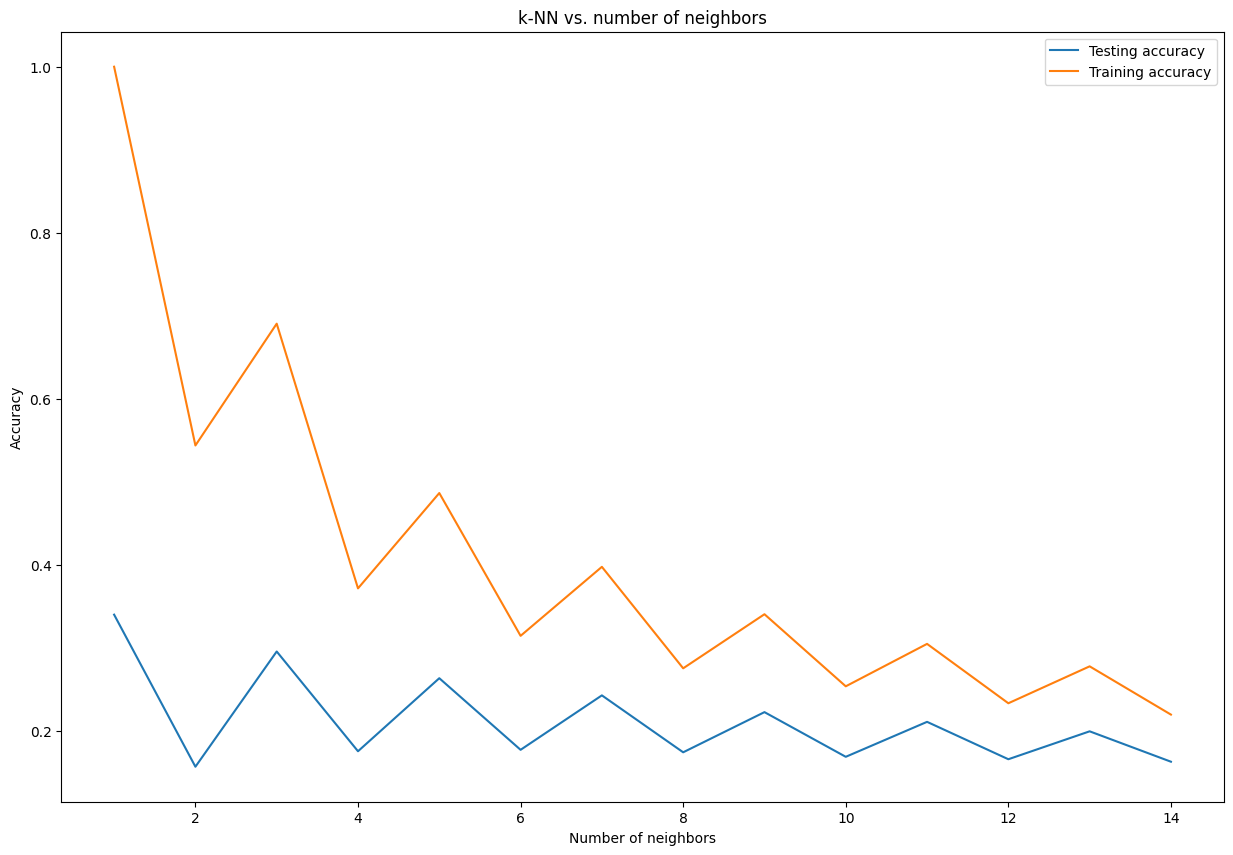

In [30]:
neighbors = range(1,15,1)
knn_train_score, knn_val_score = validation_curve(kNN(), x_train, y_train, param_name='n_neighbors', param_range=neighbors, cv=5)

plt.subplots(figsize=(15, 10))
plt.title('k-NN vs. number of neighbors')
plt.plot(neighbors, np.mean(knn_val_score, 1), label='Testing accuracy')
plt.plot(neighbors, np.mean(knn_train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [29]:
k_grid = {'n_neighbors': range(1, 10, 1)}
knn_learner = GridSearchCV(estimator=kNN(), param_grid=k_grid, cv=5, return_train_score=True)
knn_learner.fit(x_train, y_train)
knn_learner.best_params_, knn_learner.best_score_

({'n_neighbors': 1}, 0.33984352396781725)

### Decision Tree

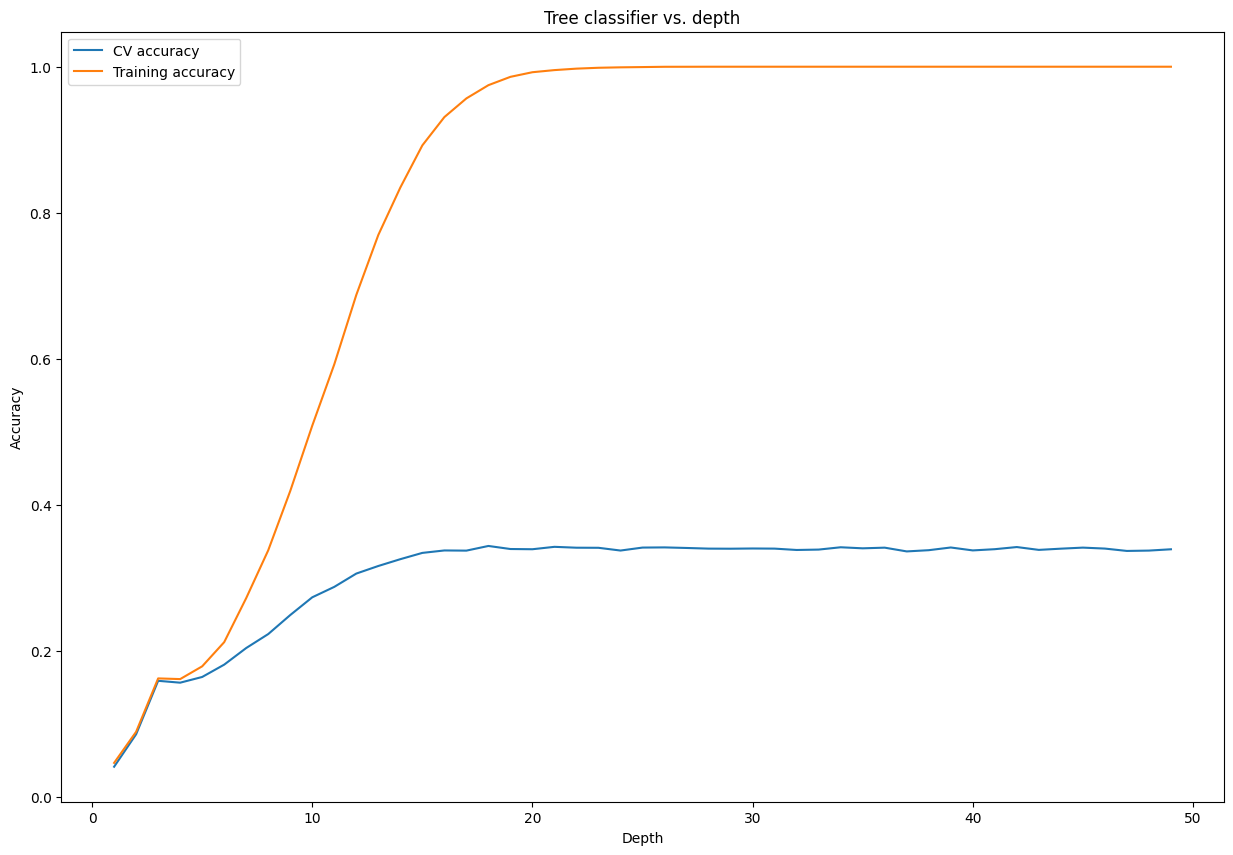

In [34]:
depths = np.arange(1,50,1)
learner = DecisionTreeClassifier()
train_score, val_score = validation_curve(learner, x_train, y_train, param_name='max_depth', param_range=depths, cv=3)

plt.subplots(figsize=(15, 10))
plt.title('Tree classifier vs. depth')
plt.plot(depths, np.mean(val_score, 1), label='CV accuracy')
plt.plot(depths, np.mean(train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

In [35]:
k_grid = {'max_depth': range(10, 30, 1)}
tree_learner = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=k_grid, cv=3, return_train_score=True)
tree_learner.fit(x_train, y_train)
tree_learner.best_params_, tree_learner.best_score_

({'max_depth': 24}, 0.34288956578868784)

In [36]:
tree_model = tree_learner.best_estimator_
tree_cv_scores = cross_val_score(tree_model, x_train, y_train, cv=5)
print("Cross-Validation Score for best Tree model: ", tree_cv_scores.mean())

Cross-Validation Score for best Tree model:  0.33864895921070615


### CNN

In [38]:
def cnn_model(nfilters1=256, nfilters2=256, nfilters3=128, nfilters4=64, size_kernel=5, nstrides=1, size_pool=5):
    model=Sequential()
    model.add(Conv1D(filters=nfilters1, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(filters=nfilters2, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(filters=nfilters3, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.1))

    model.add(Conv1D(filters=nfilters4, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=6, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    #rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.30, verbose=0, patience=2, min_lr=0.0000001)

    #model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])    
    
    #model.summary()

    return model


In [ ]:
cnn_model().fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

### Hyperparameter Tuning

In [95]:
model = KerasClassifier(
    model=cnn_model, 
    verbose=0, 
    batch_size=32, 
    loss="categorical_crossentropy", 
    nfilters1 = 64, 
    nfilters2 = 64, 
    nfilters3 = 64, 
    nfilters4 = 64, 
    size_kernel = 3,
    nstrides = 1,
    size_pool = 5
    )

In [48]:
param_grid = {
    'nfilters1': [256, 128, 64, 32],
    'nfilters2': [256, 128, 64, 32],
    'nfilters3': [256, 128, 64, 32],
    'nfilters4': [256, 128, 64, 32],
    'size_kernel': [3, 5],
    'nstrides': [1, 3],
    'size_pool': [3, 5, 8]
    #'optimizer': ['adam']
}

# Grid
grid = RandomizedSearchCV(estimator=base_model, param_distributions=param_grid, cv=3, verbose=3, n_jobs=3, n_iter=1000) #GridSearchCV
grid_result = grid.fit(x_train, y_train)

# Print
print("Best hyperparameter: ", grid_result.best_params_)
print("Best accuracy: ", grid_result.best_score_)

best_model = grid_result.best_estimator_
val_accuracy = best_model.score(x_test, y_test)
print("Validaton accuracy: ", val_accuracy)

TypeError: Cannot clone object '<keras.src.engine.sequential.Sequential object at 0x2f6c069d0>' (type <class 'keras.src.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.30, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])

### SepTr

In [7]:
# Determine batch_size and sequence_length
batch_size = 100 #Crema_df.shape[0]
sequence_lengths = []

# Loop over audio files to compute sequence lengths
for file_path in Crema_df.Path.head(100):
    audio, _ = librosa.load(file_path)  # Load audio file
    sequence_lengths.append(len(audio))

# Determine the maximum sequence length
max_sequence_length = max(sequence_lengths)
# Create a list to hold the input spectrograms
input_dim = 128  # Dimension of input spectrogram
input_spectrograms = []

# Loop over audio files again to compute and store spectrograms
for file_path in Crema_df.Path.head(100):
    audio, _ = librosa.load(file_path)  # Load audio file
    spectrogram = librosa.feature.melspectrogram(y=audio)  # Compute spectrogram
    spectrogram = librosa.power_to_db(spectrogram)  # Convert to dB scale
    spectrogram = torch.tensor(spectrogram.T)  # Transpose and convert to tensor
    input_spectrograms.append(spectrogram)

# Determine the new batch size and adjust the tensor size
batch_size = len(input_spectrograms)
input_spectrograms_resized = torch.zeros(batch_size, max_sequence_length, input_dim)
for i, spectrogram in enumerate(input_spectrograms):
    length = min(max_sequence_length, spectrogram.size(0))
    input_spectrograms_resized[i, :length, :] = spectrogram[:length, :]



In [49]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the word array and transform the words into integers
y_train = label_encoder.fit_transform(y_train)

y_test = label_encoder.fit_transform(y_test)

In [47]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Estrazione delle features e dei target dal DataFrame
features = x_train
target = integer_array

# Trasformazione in tensori PyTorch
features_tensor = torch.tensor(features, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.int8)

# Creazione del dataset
dataset = TensorDataset(features_tensor, target_tensor)

# Creazione del dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
import torch.optim as optim

num_classes = 6  # Numero di classi di output

model = AudioCNN(num_classes)

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Addestramento del modello
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.Size([1, 314])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x37 and 3840x256)

In [ ]:
input_dim = 128  # Dimension of input spectrogram
hidden_dim = 256  # Dimension of hidden layers
num_heads = 4  # Number of attention heads
num_layers = 6  # Number of SepTr encoder layers

model = SepTr(input_dim, hidden_dim, num_heads, num_layers)
output = model(input_spectrograms_resized)

### Melspectrogram

In [16]:
mel = librosa.feature.melspectrogram(y=data, sr=22050) 
mel_spec_db = librosa.power_to_db(mel)
print(mel.shape)
print(mel_spec_db.shape)

(128, 72)
(128, 72)


In [17]:
mel_spec_db

array([[-10.841489,  -9.806962, -17.02281 , ...,  -8.282634,  -6.428001,
         -9.270038],
       [-16.63483 , -13.390197, -19.89693 , ..., -14.721284,  -9.604146,
        -11.977034],
       [-15.75643 , -11.75008 , -14.732107, ..., -17.344555, -13.273731,
        -14.275537],
       ...,
       [-60.392853, -60.392853, -60.392853, ..., -60.392853, -60.392853,
        -60.392853],
       [-60.392853, -60.392853, -60.392853, ..., -60.392853, -60.392853,
        -60.392853],
       [-60.392853, -60.392853, -60.392853, ..., -60.392853, -60.392853,
        -60.392853]], dtype=float32)

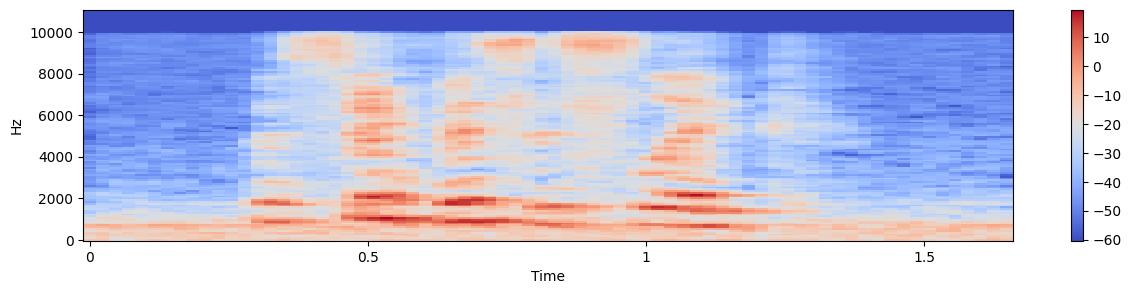

In [19]:
plt.figure(figsize=(15, 3))
librosa.display.specshow(mel_spec_db, sr=22050, x_axis='time', y_axis='hz')
plt.colorbar()

### Chromagram

In [20]:
stft = np.abs(librosa.stft(data))
chroma_stft = librosa.feature.chroma_stft(S=stft, sr=22050)

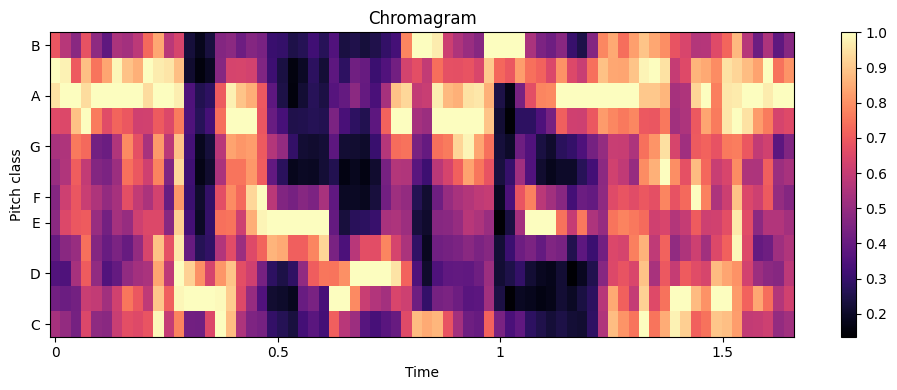

In [21]:
# Plot the chroma feature
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [22]:
chroma_stft.shape

(12, 72)